In [1]:
import os
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
from datetime import datetime
import statsmodels
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss, coint, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib
from arch.unitroot import PhillipsPerron

In [2]:
FIRST_SLICE_DATE: datetime = datetime.strptime('8/4/2019', '%d/%m/%Y')
SECOND_SLICE_DATE: datetime = datetime.strptime('1/5/2020', '%d/%m/%Y')
THIRD_SLICE_DATE: datetime = datetime.strptime('01/12/2020', '%d/%m/%Y')

In [3]:
def transform_date_series(df: pd.DataFrame, date_key: str) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, date_key] = pd.to_datetime(dff.loc[:, date_key], unit='s')
    
    return dff.set_index(date_key)

In [4]:
def filter_series(df: pd.DataFrame, slice1: datetime, slice2: datetime) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, :] = dff[dff.index > slice1]
    dff.loc[:, :] = dff[dff.index < slice2]

    return dff.dropna()

In [5]:
def print_adf(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    adf_test = adfuller(series, autolag='AIC', regression='c')
    p_value = adf_test[1]

    dfResults = pd.Series(adf_test[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    #Add Critical Values
    for key,value in adf_test[4].items():
        dfResults[f'Critical Value ({key})'] = value

    print('Augmented Dickey-Fuller Test Results:')
    print(dfResults)

In [6]:
def print_kpss(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    statistic, p_value, n_lags, critical_gasValue = kpss(series, nlags="auto", regression='c')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')

    for key, value in critical_gasValue.items():
        print(f'   {key} : {value}')

# GAS series

Loading and cleaning gas data.

In [7]:
gas: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'avg_gas_price.csv'), header=0)
gas.rename(columns={'UnixTimeStamp': 'date', 'Value (Wei)': 'gasValue'}, inplace = True)
gas = gas[['date', 'gasValue']].dropna()
gas = transform_date_series(df=gas, date_key='date')

## Original series

Let's see how the series looks like.

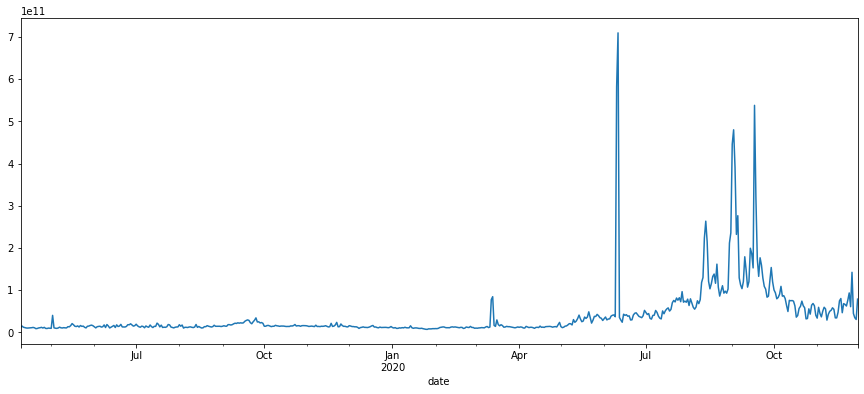

In [8]:
gas_plot = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
gas_plot['gasValue'].plot(figsize = (15, 6))
plt.show()

## Splitting the series

We can see there is two-stage in the series. The first stage ends around May first of 2020, from then the series changed. So let's split the series into two slices. 

In [9]:
gas_slice2 = filter_series(df=gas, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)
gas_slice2['gasValue'] = np.log(gas_slice2['gasValue'] / gas_slice2['gasValue'].shift(1))
gas_slice2.dropna(inplace=True)
#gas_slice2['gasValue'] = np.log(gas_slice2['gasValue'])

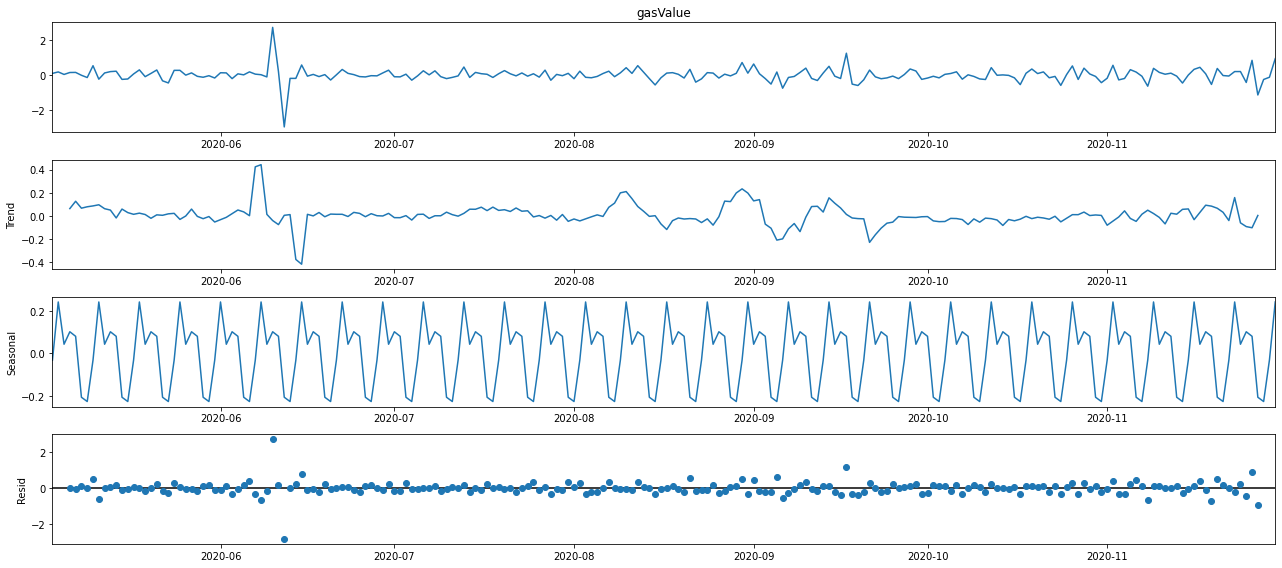

In [10]:
#rcParams['figure.figsize'] = 18, 8
#res = STL(gas_slice2['gasValue']).fit()
#res.plot()
#plt.show()

rcParams['figure.figsize'] = 18, 8
res = sm.tsa.seasonal_decompose(x=gas_slice2['gasValue'], model='additive')
fig = res.plot()
plt.show()

In [11]:
gas_slice2['gasValue'] = gas_slice2['gasValue'] - res.seasonal

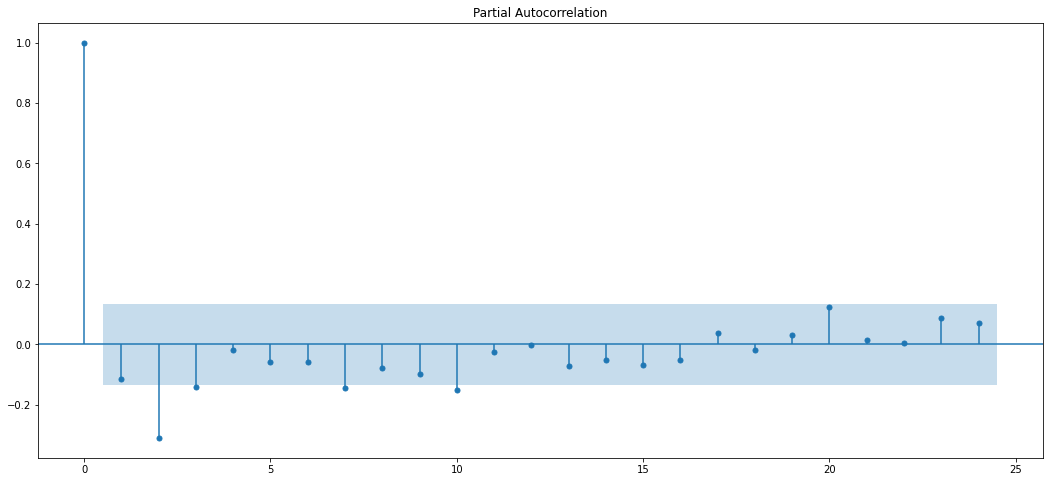

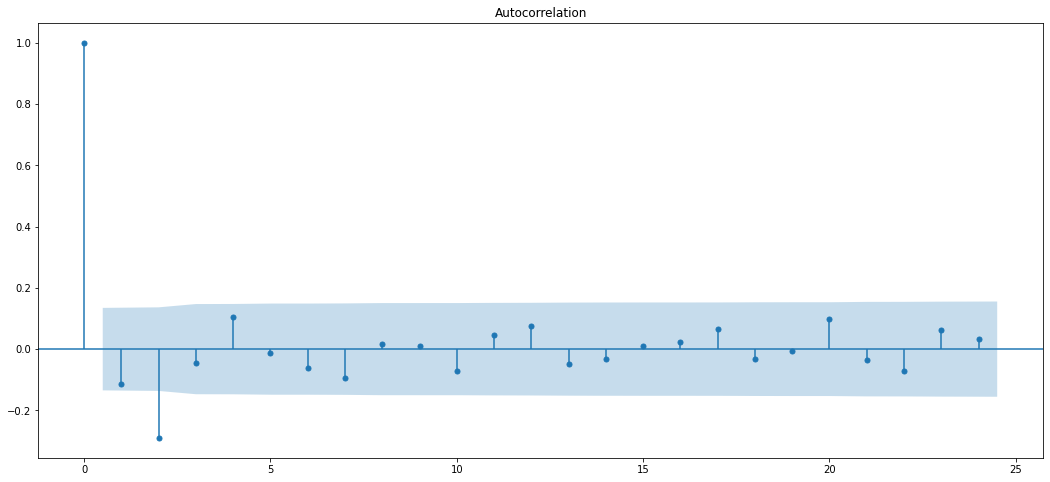

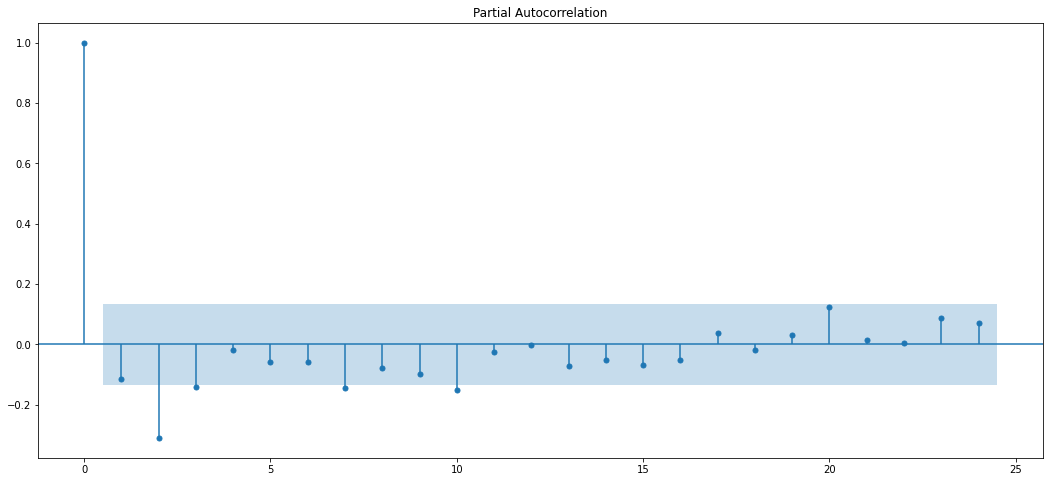

In [12]:
#gas_slice2['gasValue'].plot(figsize = (15, 6))
#plt.show()

#rcParams['figure.figsize'] = 18, 8
#decomposition = sm.tsa.seasonal_decompose(x=gas_slice2['gasValue'], model='additive')
#fig = decomposition.plot()
#plt.show()

statsmodels.graphics.tsaplots.plot_acf(gas_slice2['gasValue'])
statsmodels.graphics.tsaplots.plot_pacf(gas_slice2['gasValue'])

#res = STL(gas_slice2['gasValue']).fit()
#res.plot()
#plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [13]:
print_adf(df=gas_slice2, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.175928e+01
P-Value                 1.158373e-21
# Lags Used             2.000000e+00
# Observations Used     2.090000e+02
Critical Value (1%)    -3.462032e+00
Critical Value (5%)    -2.875471e+00
Critical Value (10%)   -2.574195e+00
dtype: float64


## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [14]:
print_kpss(df=gas_slice2, key='gasValue')

KPSS Statistic: 0.1974962898296783
p-value: 0.1
num lags: 43
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Phillips–Perron (PP) test

In [15]:
pp = PhillipsPerron(gas_slice2['gasValue'])
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -22.866
P-value                         0.000
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# DAOstack activity-membership rate series

Let's check the series.

In [16]:
daostack: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'daostack_activity_membership_rate.csv'), header=0)
daostack = transform_date_series(df=daostack, date_key='date')

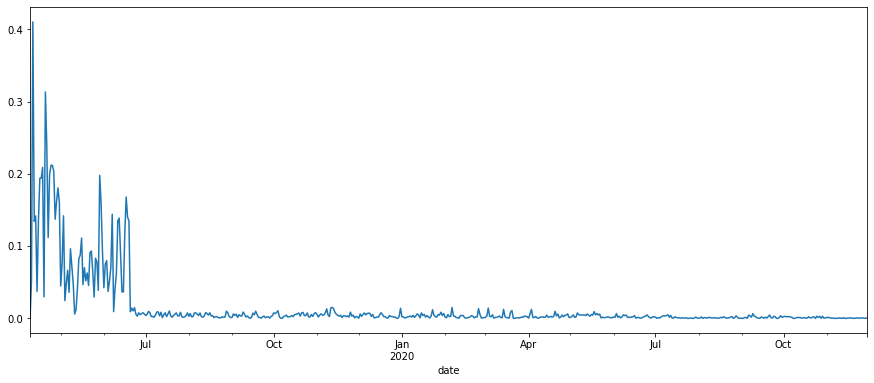

In [17]:
daostack_plot = filter_series(df=daostack, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
daostack_plot['rateActionsMembers'].plot(figsize = (15, 6))
plt.show()

## Spliting the series

As we previously do with the gas series, let's split the series.

In [18]:
daostack_slice2 = filter_series(df=daostack, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)
daostack_slice2.drop(daostack_slice2.index[0], inplace=True)

In [19]:
daostack_slice2.describe()

,rateActionsMembers
count,212.000000
mean,0.001668
std,0.001704
min,0.000000
25%,0.000453
50%,0.001071
75%,0.002282
max,0.009375


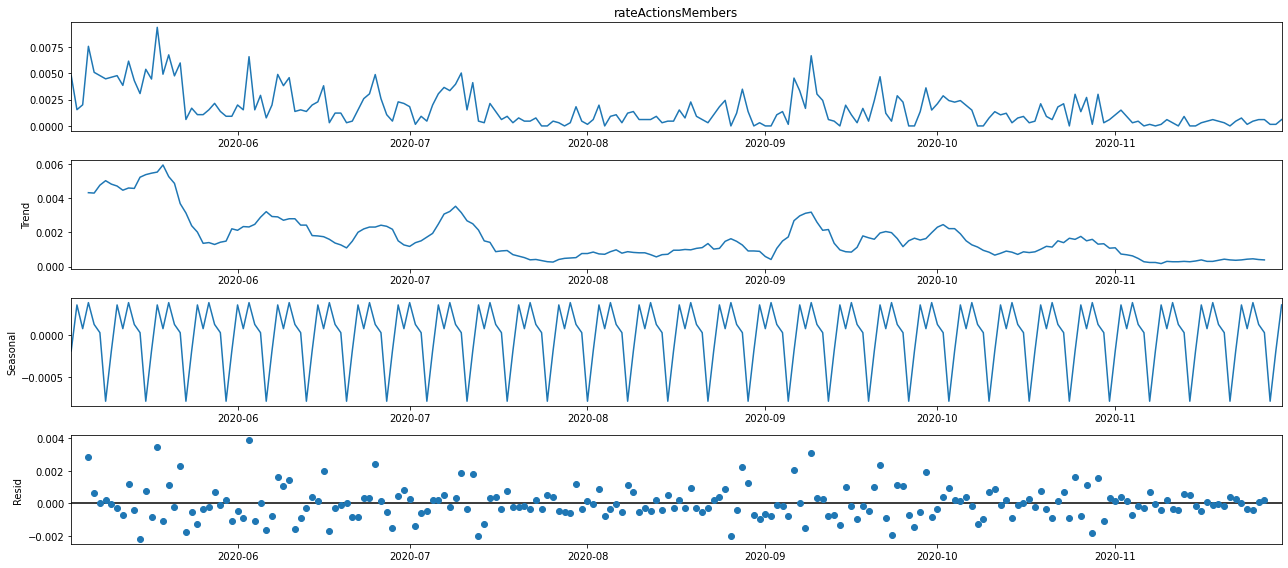

In [20]:
#rcParams['figure.figsize'] = 18, 8
#res = STL(daostack_slice2['rateActionsMembers']).fit()
#res.plot()
#plt.show()

rcParams['figure.figsize'] = 18, 8
res = sm.tsa.seasonal_decompose(x=daostack_slice2['rateActionsMembers'], model='additive')
fig = res.plot()
plt.show()

In [21]:
daostack_slice2['rateActionsMembers'] = daostack_slice2['rateActionsMembers'] - res.seasonal
#daostack_slice2.dropna(inplace=True)

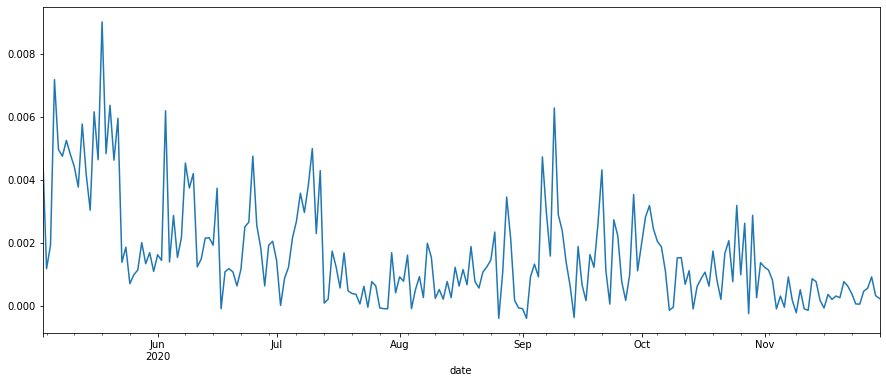

In [22]:
daostack_slice2['rateActionsMembers'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [23]:
print_adf(df=daostack_slice2, key='rateActionsMembers')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.576827
P-Value                   0.000142
# Lags Used               1.000000
# Observations Used     210.000000
Critical Value (1%)      -3.461879
Critical Value (5%)      -2.875404
Critical Value (10%)     -2.574159
dtype: float64


## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [24]:
print_kpss(df=daostack_slice2, key='rateActionsMembers')

KPSS Statistic: 1.1316194682410172
p-value: 0.01
num lags: 8
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## Phillips–Perron (PP) test

In [25]:
pp = PhillipsPerron(daostack_slice2['rateActionsMembers'])
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -9.225
P-value                         0.000
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# Granger Causality Tests

Where:

    * H0: The second column, x2, does NOT Granger cause the time series in the first column, x1
    * H1: x2 Granger cause x1

In [26]:
slice2: pd.DataFrame = pd.DataFrame(
    {'rateActionsMembers': daostack_slice2['rateActionsMembers'].tolist(),
     'gasValue': gas_slice2['gasValue'].tolist(),
    })
    
gc_res2 = grangercausalitytests(slice2, 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0045  , p=0.9466  , df_denom=208, df_num=1
ssr based chi2 test:   chi2=0.0046  , p=0.9461  , df=1
likelihood ratio test: chi2=0.0046  , p=0.9461  , df=1
parameter F test:         F=0.0045  , p=0.9466  , df_denom=208, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8254  , p=0.1638  , df_denom=205, df_num=2
ssr based chi2 test:   chi2=3.7399  , p=0.1541  , df=2
likelihood ratio test: chi2=3.7070  , p=0.1567  , df=2
parameter F test:         F=1.8254  , p=0.1638  , df_denom=205, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5252  , p=0.2091  , df_denom=202, df_num=3
ssr based chi2 test:   chi2=4.7343  , p=0.1923  , df=3
likelihood ratio test: chi2=4.6814  , p=0.1967  , df=3
parameter F test:         F=1.5252  , p=0.2091  , df_denom=202, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2843  , p=0.2775  

# VAR analysis

In [27]:
slice2: pd.DataFrame = gas_slice2.copy(deep=True)
slice2['rateActionsMembers'] = daostack_slice2['rateActionsMembers'].tolist()

In [28]:
model2 = sm.tsa.VAR(slice2)
model2.select_order(24).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,-15.25,-15.21,2.385e-07,-15.23
1,-15.41,-15.30,2.036e-07,-15.37
2,-15.56*,-15.38*,1.756e-07*,-15.49*
3,-15.55,-15.31,1.765e-07,-15.45
4,-15.51,-15.20,1.832e-07,-15.39
5,-15.47,-15.10,1.905e-07,-15.32
6,-15.44,-15.00,1.966e-07,-15.26
7,-15.47,-14.96,1.907e-07,-15.26
8,-15.47,-14.88,1.914e-07,-15.23
9,-15.54,-14.88,1.794e-07,-15.27


In [29]:
results2 = model2.fit(maxlags=2, ic='aic')
results2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 10, Jan, 2021
Time:                     13:06:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -15.2418
Nobs:                     210.000    HQIC:                  -15.3368
Log likelihood:           1031.17    FPE:                2.04806e-07
AIC:                     -15.4012    Det(Omega_mle):     1.95391e-07
--------------------------------------------------------------------
Results for equation gasValue
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        -0.017444         0.036599           -0.477           0.634
L1.gasValue                  -0.153309         0.067004           -2.288           0.022
L1.rateActionsMembers    

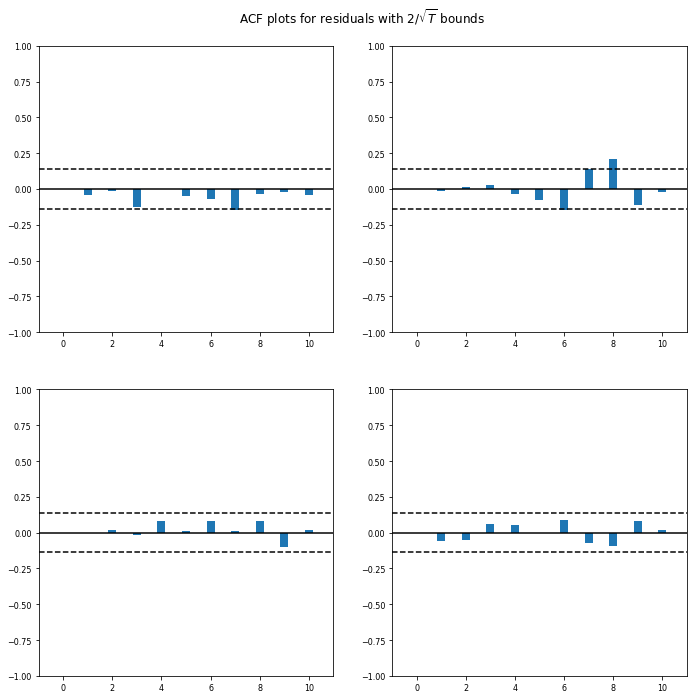

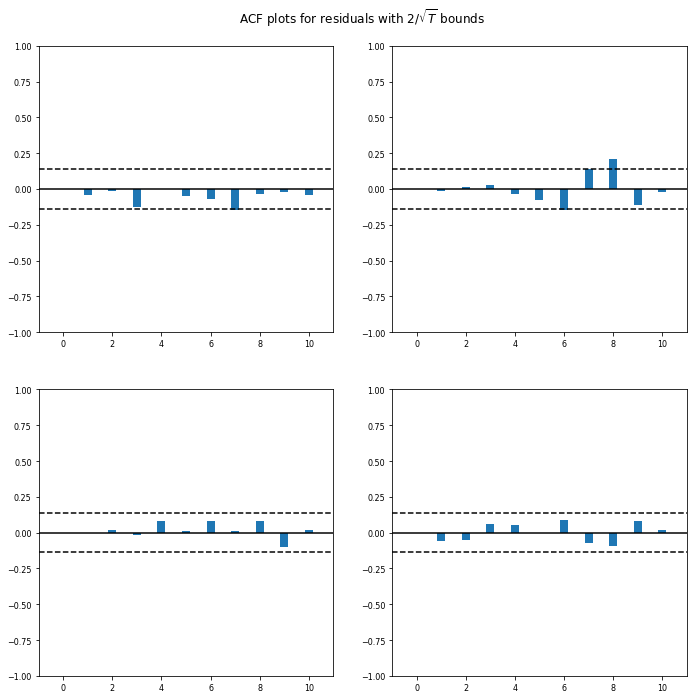

In [30]:
results2.plot_acorr()

### Impulse Response

In [31]:
irf2 = results2.irf(20)

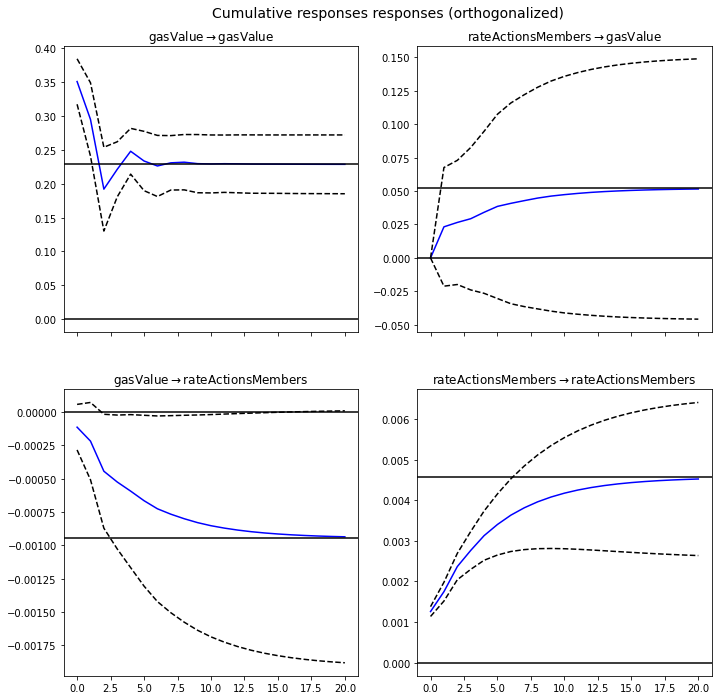

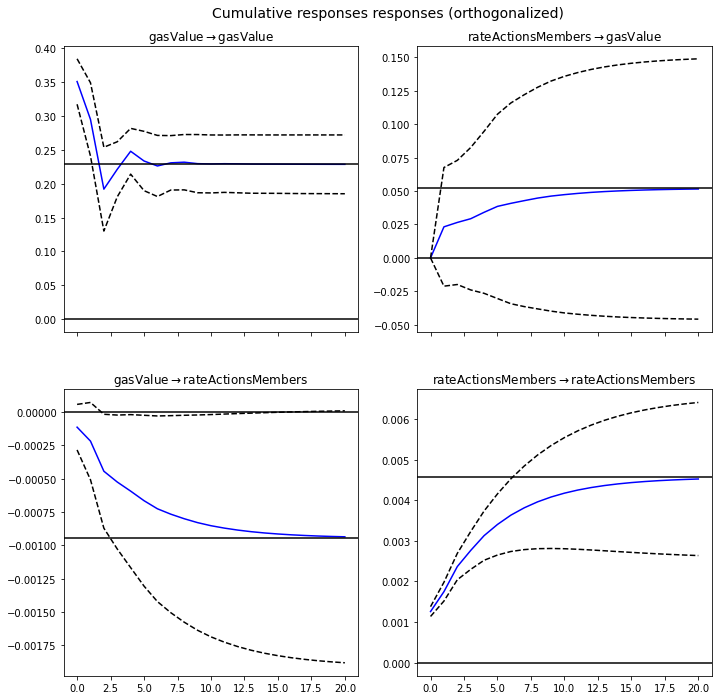

In [32]:
irf2.plot_cum_effects(orth=True)

In [33]:
results2.fevd(periods=20).summary()

FEVD for gasValue
      gasValue  rateActionsMembers
0     1.000000            0.000000
1     0.995734            0.004266
2     0.995985            0.004015
3     0.995954            0.004046
4     0.995810            0.004190
5     0.995676            0.004324
6     0.995641            0.004359
7     0.995612            0.004388
8     0.995586            0.004414
9     0.995570            0.004430
10    0.995562            0.004438
11    0.995556            0.004444
12    0.995552            0.004448
13    0.995549            0.004451
14    0.995547            0.004453
15    0.995546            0.004454
16    0.995546            0.004454
17    0.995545            0.004455
18    0.995545            0.004455
19    0.995545            0.004455

FEVD for rateActionsMembers
      gasValue  rateActionsMembers
0     0.008132            0.991868
1     0.012939            0.987061
2     0.032820            0.967180
3     0.033302            0.966698
4     0.033336            0.966664
5     0.

In [34]:
results2.test_normality().summary()

Test statistic,Critical value,p-value,df
2671.,9.488,0.000,4


In [35]:
results2.test_whiteness(nlags=20).summary()

Test statistic,Critical value,p-value,df
90.63,92.81,0.068,72


In [36]:
results2.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
1.694,3.841,0.193,1


In [37]:
results2.test_causality(caused='rateActionsMembers',causing='gasValue').summary()

Test statistic,Critical value,p-value,df
1.825,3.018,0.162,"(2, 410)"
